# ORÁCULO

http://www.lotoideas.com/primitiva-resultados-historicos-de-todos-los-sorteos/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

import time
import operator

Using TensorFlow backend.


In [2]:
#Muestra una grafica de la evolucion del error de training y validacion
def grafica(hist, offset0 = 0, offset1 = None):
    loss = hist.history['loss'][offset0:offset1]
    val_loss = hist.history['val_loss'][offset0:offset1]
    epochs = range(offset0 + 1, len(loss) + offset0 + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [3]:
#Funciones para mostrar tiempo transcurrido
def print_time(time_ini):
    sec = round(time.time() - time_ini)
    min = 0
    if(sec > 60):
        min = sec // 60
        sec = sec & 60
    print("TIME: ", min, "m  ", sec, "s")

def ini_time():
    print("Procesando... ", time.ctime())
    return time.time()

In [4]:
import winsound
def beep():
    duration = 500  # millisecond
    freq = 900  # Hz
    winsound.Beep(freq, duration)
    winsound.Beep(freq, duration)
    winsound.Beep(freq, 2*duration)

In [5]:
#Calcula el error incurrido en la predicción
import math
def calc_error(pred, real):
    error = []
    for i in range(len(pred)):
        error.append(0)
        for j in range(len(pred[i])):
            if(pred[i][j] not in real[i]):
                error[i] += 1
    for i in range(len(error)):
        error[i] = math.floor(error[i]*100.0/6.0)
    return error

In [58]:
#TODO: Si el peor de los mejores esta repetido, alguno mejor podria no entrar en la lista
def traduce(pred):
    numeros = []
    for i in range(pred.shape[0]):
        min_mas_alto = sorted(pred[i], key=float, reverse=True)[5]
        numeros.append([])
        for j in range(pred.shape[1]):
            if pred[i][j] >= min_mas_alto and len(numeros[i]) < 6:
                numeros[i].append(j)
    return numeros

def traduce_uno(pred):
    numeros = []
    min_mas_alto = sorted(pred, key=float, reverse=True)[5]
    for j in range(pred.shape[0]):
        if pred[j] >= min_mas_alto and len(numeros) < 6:
            numeros.append(j)
    return numeros

# --------------------------------------------------------------------------------------------------------------

In [7]:
#Cargar datos
datos = pd.read_csv('Primitiva_2013_2018.csv')

datos = datos.drop(labels=['comp'], axis=1)

print(datos.head())
print()
#Poner los datos mas recientes al final...
datos = datos.reindex(index=datos.index[::-1])
print(datos.head())
print()

max = datos.max(1).max()
min = datos.min(1).min()
print("MAX: ", max)#49
print("MIN: ", min)# 1
print("DIM: ", datos.shape)
features = max - min +1

        fecha  n1  n2  n3  n4  n5  n6
0  27/01/2018   7   8  10  14  27  48
1  25/01/2018   3   6  25  31  32  40
2  20/01/2018  15  23  28  36  39  47
3  18/01/2018  11  12  22  28  37  49
4  13/01/2018   6   7  22  31  38  44

          fecha  n1  n2  n3  n4  n5  n6
529   3/01/2013   3  15  23  26  34  38
528   5/01/2013   1   4   9  11  38  48
527  10/01/2013  29  32  34  42  44  46
526  12/01/2013   2   3  19  20  29  37
525  17/01/2013   1  23  30  41  43  49

MAX:  49
MIN:  1
DIM:  (530, 7)


In [8]:
#Convierte los numeros enteros premiados en un array binario
def vectorize(sequences, dimension=features):
    res = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        res[i, sequence-min] = 1
    return res

def devectorize(valor):
    res = []
    for i in range(len(valor)):
        if(valor[i] > 0):
            res.append(i+min)
    return res
#print(devectorize(np.array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0])), "\n")

numeros = datos.drop(labels=['fecha'], axis=1)
print("----------------------------------------\n")
print(numeros.head())
print("----------------------------------------\n")
print(np.array(numeros))
print("----------------------------------------\n")
num_hot = vectorize(np.array(numeros))
print(devectorize(num_hot[0]))
print(devectorize(num_hot[1]))
print(devectorize(num_hot[2]))
print("...")

----------------------------------------

     n1  n2  n3  n4  n5  n6
529   3  15  23  26  34  38
528   1   4   9  11  38  48
527  29  32  34  42  44  46
526   2   3  19  20  29  37
525   1  23  30  41  43  49
----------------------------------------

[[ 3 15 23 26 34 38]
 [ 1  4  9 11 38 48]
 [29 32 34 42 44 46]
 ...
 [15 23 28 36 39 47]
 [ 3  6 25 31 32 40]
 [ 7  8 10 14 27 48]]
----------------------------------------

[3, 15, 23, 26, 34, 38]
[1, 4, 9, 11, 38, 48]
[29, 32, 34, 42, 44, 46]
...


In [9]:
#Divide los datos en secuencias que el modelo tendrá que aprender
seq_len = 100
secuencias = []
print(len(num_hot), seq_len)
for index in range(len(num_hot) - seq_len):
    secuencias.append(num_hot[index : index + seq_len])
secuencias = np.array(secuencias)
###
"""
print(devectorize(num_hot[0]))
print(devectorize(secuencias[0][0]))
print()
print(devectorize(num_hot[seq_len-1]))
print(devectorize(secuencias[0][seq_len-1]))
print()
print(devectorize(num_hot[1]))
print(devectorize(secuencias[1][0]))
print()
print(devectorize(num_hot[1+seq_len-1]))
print(devectorize(secuencias[1][seq_len-1]))
print()

print(devectorize(secuencias[0][0]))
print("...")
"""

530 100


'\nprint(devectorize(num_hot[0]))\nprint(devectorize(secuencias[0][0]))\nprint()\nprint(devectorize(num_hot[seq_len-1]))\nprint(devectorize(secuencias[0][seq_len-1]))\nprint()\nprint(devectorize(num_hot[1]))\nprint(devectorize(secuencias[1][0]))\nprint()\nprint(devectorize(num_hot[1+seq_len-1]))\nprint(devectorize(secuencias[1][seq_len-1]))\nprint()\n\nprint(devectorize(secuencias[0][0]))\nprint("...")\n'

In [10]:
#Divide los datos en Training y Test
print(secuencias.shape)
row = round(0.9 * secuencias.shape[0])
train = secuencias[:int(row), :]
print(train.shape)
print(devectorize(train[0][0]))
print(devectorize(secuencias[0][0]))

#np.random.shuffle(train)

x_train = train[:, :-1]#Todos menos el ultimo valor, que es el que hay que predecir
print(x_train.shape)
print(x_train[0][0])

y_train = train[:, -1] #El ultimo valor, que es el que interesa predecir
print(y_train.shape)
x_test = secuencias[int(row):, :-1]
print(x_test.shape)
y_test = secuencias[int(row):, -1]
print(y_test.shape)


(430, 100, 49)
(387, 100, 49)
[3, 15, 23, 26, 34, 38]
[3, 15, 23, 26, 34, 38]
(387, 99, 49)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
(387, 49)
(43, 99, 49)
(43, 49)


In [11]:
"""
print(x_train.shape,  seq_len)

print()
print(devectorize(num_hot[0]))
print(devectorize(x_train[0][0]))
print()
print(devectorize(num_hot[seq_len-2]))
print(devectorize(x_train[0][seq_len-2]))
print()
print(devectorize(num_hot[seq_len-1]))
print(devectorize(y_train[0]))
print()
print(devectorize(num_hot[x_train.shape[0]+seq_len-2]))
print(devectorize(x_test[0][seq_len-2]))
print()
print(devectorize(num_hot[x_train.shape[0]+seq_len-1]))
print(devectorize(y_test[0]))
"""

'\nprint(x_train.shape,  seq_len)\n\nprint()\nprint(devectorize(num_hot[0]))\nprint(devectorize(x_train[0][0]))\nprint()\nprint(devectorize(num_hot[seq_len-2]))\nprint(devectorize(x_train[0][seq_len-2]))\nprint()\nprint(devectorize(num_hot[seq_len-1]))\nprint(devectorize(y_train[0]))\nprint()\nprint(devectorize(num_hot[x_train.shape[0]+seq_len-2]))\nprint(devectorize(x_test[0][seq_len-2]))\nprint()\nprint(devectorize(num_hot[x_train.shape[0]+seq_len-1]))\nprint(devectorize(y_test[0]))\n'

# --------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------

#### OBJETIVO MINIMO: OK 33.33 !!!

model1 ->

4 capas LSTM, 1 densa, epoca=35, 5m0s/200e -> OK 16.6

5 capas LSTM, 1 densa, epoca=81, 4m40s/150e -> OK 30.44 !!!

6 capas LSTM, 1 densa, epoca=150, 11m/150e -> OK 




In [12]:
#Crea la RNN
def build_model():
    model = models.Sequential()
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))
    #model.add(layers.Dropout(0.2))
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))

    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=False))
    #model.add(layers.Dropout(0.2))

    model.add(layers.Dense(units=features, activation='sigmoid'))
    #model.add(layers.Dense(units=features))
    #model.add(layers.Activation("linear"))

    #start = time.time()
    #model.compile(loss="mse", optimizer="rmsprop")
    model.compile(loss="mse", optimizer="rmsprop")
    #print("> Compilation Time : ", round(time.time() - start), " segundos")
    return model

##
def build_model2():
    model = models.Sequential()
    
    model.add(layers.LSTM(
        input_shape=(None, features),
        units=features,
        return_sequences=True))
    
    #model.add(layers.Embedding(features, 32))
    model.add(layers.Bidirectional(layers.LSTM(input_shape=(None, features), units=features, return_sequences=True)))
    model.add(layers.Dense(features, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model


In [13]:
#Entrenar la RNN
batch_size=128
epochs = 150
model = build_model()
timeini = ini_time()
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)
print_time(timeini)

Procesando...  Thu Feb  1 09:08:21 2018
TIME:  8 m   32 s


Val.Loss:  0.10769730061292648


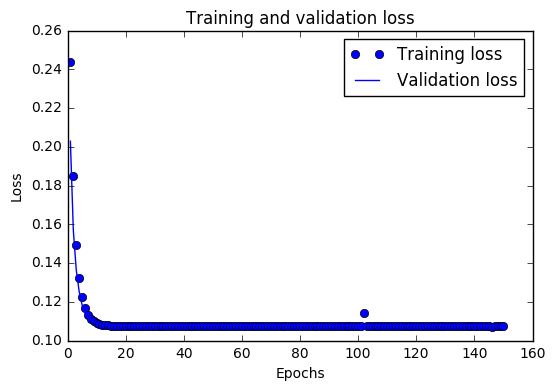

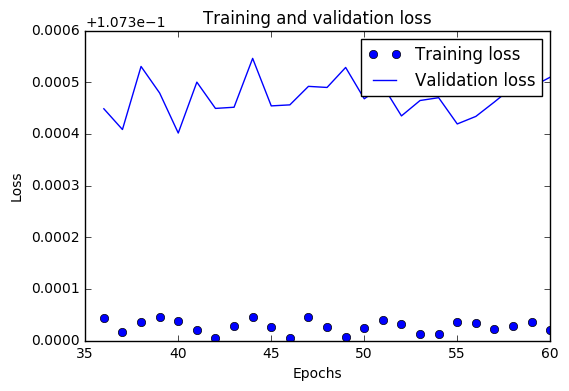

In [23]:
print("Val.Loss: ", hist.history['val_loss'][epochs-1])
grafica(hist)
grafica(hist, 35, 60)

In [24]:
timeini = ini_time()
best_epoch = 40
model2 = build_model()
hist2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=best_epoch, validation_split=0.05, verbose=0)
print_time(timeini)

Procesando...  Thu Feb  1 09:28:06 2018
TIME:  2 m   60 s


Val.Loss:  0.10780008137226105


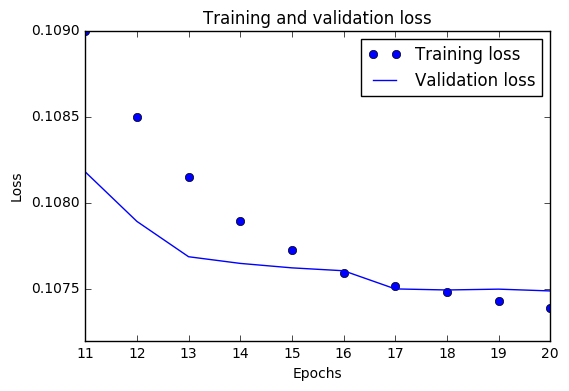

In [25]:
print("Val.Loss: ", hist.history['val_loss'][best_epoch])
grafica(hist2, 10, 20)

In [29]:
numeros_ganadores = traduce(model2.predict(x_test))
print("REAL: ", devectorize(y_test[0]))
print()
print("PRED: ", numeros_ganadores[0])
##
error = calc_error(numeros_ganadores, y_test)
print("ERROR: ", error)
err = 0
for x in error:
    err += x
print("\nERROR:   %.2f -------------------------------" % (err/len(error)))
print("\nACIERTO: %.2f -------------------------------" % (100 - err/len(error)))

model2.save("lotoB"+str(acierto100)+".h5")

REAL:  [4, 15, 20, 35, 39, 41]

PRED:  [2, 10, 11, 29, 42, 45]
ERROR:  [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 100, 83]

ERROR:   94.07 -------------------------------

ACIERTO: 5.93 -------------------------------


In [18]:
numeros_ganadores = traduce(model.predict(x_test))
error = calc_error(numeros_ganadores, y_test)
print("ERROR: ", error)
err = 0
for x in error:
    err += x
    
error100 = err/len(error)
acierto100 = 100 - error100
print("\nERROR:   %.2f -------------------------------" % error100)
print("\nACIERTO: %.2f -------------------------------" % acierto100)

model.save("lotoA"+str(acierto100)+".h5")

ERROR:  [100, 83, 83, 66, 50, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]

ERROR:   38.05 -------------------------------

ACIERTO: 61.95 -------------------------------


In [21]:
#TODO: Modificar porcentage TRAIN / TEST a ver como responde...

In [113]:
#Predecir
print(secuencias.shape)
print(secuencias[-51:-1].shape)
numeros_ganadores = model.predict(secuencias[-51:-1])
numeros_ganadores = traduce_uno(numeros_ganadores[-1])
print(numeros_ganadores, " vs real ", devectorize(secuencias[-1][-1]))
print()

numeros_ganadores = model.predict(secuencias[-50:])
numeros_ganadores = traduce_uno(numeros_ganadores[-1])
print("----------------------------------------------------------------")
print(numeros_ganadores)
print("----------------------------------------------------------------")

print()
print(num_hot.shape)
numeros = num_hot[-250:-78]
print(numeros.shape)
numeros = numeros.reshape(1,numeros.shape[0], numeros.shape[1])
print(numeros.shape)

numeros_ganadores = model.predict(numeros)
numeros_ganadores = traduce_uno(numeros_ganadores[-1])
print("----------------------------------------------------------------")
print(numeros_ganadores)
print("----------------------------------------------------------------")



(430, 100, 49)
(50, 100, 49)
[10, 11, 29, 42, 45, 48]  vs real  [3, 6, 25, 31, 32, 40]

----------------------------------------------------------------
[10, 11, 29, 42, 45, 48]
----------------------------------------------------------------

(530, 49)
(172, 49)
(1, 172, 49)
----------------------------------------------------------------
[3, 10, 11, 29, 42, 48]
----------------------------------------------------------------
